<a href="https://colab.research.google.com/github/navyaravi/INFO_5731_Spring_2021/blob/main/In_class_exercise_07.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **The seventh in-class-exercise (20 points in total, 3/16/2021)**

**Downloading and Installing required modules**

**Installing nltk and stopwords**

In [1]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

**Installing Java**

In [23]:

import os
def install_java():
  !apt-get install -y openjdk-8-jdk-headless -qq > /dev/null
  os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
  !java -version
install_java()

openjdk version "11.0.10" 2021-01-19
OpenJDK Runtime Environment (build 11.0.10+9-Ubuntu-0ubuntu1.18.04)
OpenJDK 64-Bit Server VM (build 11.0.10+9-Ubuntu-0ubuntu1.18.04, mixed mode, sharing)


**Upgrading Gensim**

In [2]:
!pip install --upgrade gensim

     |████████████████████████████████| 24.2MB 5.4MB/s 
  Found existing installation: gensim 3.6.0
    Uninstalling gensim-3.6.0:
      Successfully uninstalled gensim-3.6.0


**Downloading en module in spicy**

In [3]:
import spacy.cli
spacy.cli.download("en")

✔ Download and installation successful
You can now load the model via spacy.load('en_core_web_sm')
✔ Linking successful
/usr/local/lib/python3.7/dist-packages/en_core_web_sm -->
/usr/local/lib/python3.7/dist-packages/spacy/data/en
You can now load the model via spacy.load('en')


In [30]:
!pip install pyLDAvis

     |████████████████████████████████| 1.7MB 4.6MB/s 
  Created wheel for pyLDAvis: filename=pyLDAvis-3.2.2-py2.py3-none-any.whl size=135593 sha256=90a7705919daaa943dba7740388ccfe903a10fa5a736603f0fed38d16fa8f507
  Stored in directory: /root/.cache/pip/wheels/74/df/b6/97234c8446a43be05c9a8687ee0db1f1b5ade5f27729187eae
Successfully built pyLDAvis


Question description: In the last in-class-exercise (exercise-06), you collected the titles of 100 articles about data science, natural language processing, and machine learning. The 100 article titles will be used as the text corpus of this exercise. Perform the following tasks:

## (1) (8 points) Generate K topics by using LDA, the number of topics K should be decided by the coherence score, then summarize what are the topics. You may refer the code here: 

https://www.machinelearningplus.com/nlp/topic-modeling-gensim-python/

**Importing Required Modules**

In [32]:
# Write your code here
import re
import numpy as np
import pandas as pd
from pprint import pprint
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel
import spacy
import pyLDAvis
import pyLDAvis.gensim
import matplotlib.pyplot as plt
%matplotlib inline
import warnings
warnings.filterwarnings("ignore",category=DeprecationWarning)


**Importing Stopwords module from nltk**

In [7]:
from nltk.corpus import stopwords
stop_words = stopwords.words('english')
stop_words.extend(['from', 'subject', 're', 'edu', 'use'])

**Reading Google Articles from csv to df**

In [11]:
google_articles_titles = pd.read_csv('/content/google_scholar_articles.csv', encoding = "ISO-8859-1")
google_articles_titles.head(10)

,Title
0,Avoiding the undefined by underspecification
1,Using Valgrind to Detect Undefined Value Error...
2,Waste to bioproduct conversion with undefined ...
3,Achieving empirical progress in an undefined f...
4,Undefined by data: a survey of big data defini...
5,Chronic rejectionan undefined conundrum
6,Intelligence defined and undefined: A relativi...
7,Undefined behavior: what happened to my code?
8,Towards optimization-safe systems: Analyzing t...
9,Clinical characteristics and genetic analyses ...


**Dataframe to list**

In [13]:
data = google_articles_titles['Title'].tolist()

**Tokenization and punctuation**

In [14]:
data_words = []
for line in data:
  data_words.append(gensim.utils.simple_preprocess(str(line), deacc=True))

**Building Bigrams and Trigrams models**

In [15]:
bigram = gensim.models.Phrases(data_words, min_count=5, threshold=100)
trigram = gensim.models.Phrases(bigram[data_words], threshold=100)
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

**Removing Stopwords and getting Bigrams**

In [16]:
after_stopword_removal = [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in data_words]
bigrams = [bigram_mod[doc] for doc in after_stopword_removal]

**Lemmatization**

In [17]:
nlp = spacy.load('en', disable=['parser', 'ner'])
allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']
after_lemmatization = []
for sent in bigrams:
  doc = nlp(" ".join(sent)) 
  after_lemmatization.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])

**Building Dictionary, Corpus and Term Document Frequency**

In [18]:
id2word = corpora.Dictionary(after_lemmatization)
texts = after_lemmatization
corpus = [id2word.doc2bow(text) for text in after_lemmatization]
print(corpus[:1])

[[(0, 1), (1, 1)]]


In [19]:
[[(id2word[id], freq) for id, freq in cp] for cp in corpus[:1]]

[[('avoid', 1), ('undefined', 1)]]

**Building LDA Model with 20 topics**

In [20]:
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=20, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=100,
                                           passes=10,
                                           alpha='auto',
                                           per_word_topics=True)

**Compute Model Perplexity and Coherence Score**

In [21]:
print('\nPerplexity: ', lda_model.log_perplexity(corpus)) 
coherence_model_lda = CoherenceModel(model=lda_model, texts=after_lemmatization, dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)


Perplexity:  -12.285982085935096

Coherence Score:  0.403157876226733


**Setting environment Path and giving Mallet Path**

In [45]:

!wget http://mallet.cs.umass.edu/dist/mallet-2.0.8.zip
!unzip mallet-2.0.8.zip

--2021-03-19 19:44:43--  http://mallet.cs.umass.edu/dist/mallet-2.0.8.zip
Resolving mallet.cs.umass.edu (mallet.cs.umass.edu)... 128.119.246.70
Connecting to mallet.cs.umass.edu (mallet.cs.umass.edu)|128.119.246.70|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 16184794 (15M) [application/zip]
Saving to: ‘mallet-2.0.8.zip’

mallet-2.0.8.zip    100%[===================>]  15.43M  16.9MB/s    in 0.9s    

2021-03-19 19:44:44 (16.9 MB/s) - ‘mallet-2.0.8.zip’ saved [16184794/16184794]

Archive:  mallet-2.0.8.zip
   creating: mallet-2.0.8/
   creating: mallet-2.0.8/bin/
  inflating: mallet-2.0.8/bin/classifier2info  
  inflating: mallet-2.0.8/bin/csv2classify  
  inflating: mallet-2.0.8/bin/csv2vectors  
  inflating: mallet-2.0.8/bin/mallet  
  inflating: mallet-2.0.8/bin/mallet.bat  
  inflating: mallet-2.0.8/bin/mallethon  
  inflating: mallet-2.0.8/bin/prepend-license.sh  
  inflating: mallet-2.0.8/bin/svmlight2vectors  
  inflating: mallet-2.0.8/bin/text2classi

In [46]:

import os
os.environ.update({'MALLET_HOME' : r'/content/mallet-2.0.8/'})
mallet_path = '/content/mallet-2.0.8/bin/mallet'
#ldamallet = gensim.models.wrappers.LdaMallet(mallet_path, corpus=corpus, num_topics=10, id2word=id2word)

#import os
    #os.environ.update({'MALLET_HOME': r'C:/new_mallet/mallet-2.0.8/'})
    #mallet_path = 'C:/new_mallet/mallet-2.0.8/bin/mallet'  # update this path
    #

**Building LDA Mallet Model**

In [47]:
ldamallet = gensim.models.wrappers.LdaMallet(mallet_path, corpus=corpus, num_topics=20, id2word=id2word)

**Compute Coherence Value for LDA**

In [48]:
def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=3):
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model = gensim.models.wrappers.LdaMallet(mallet_path, corpus=corpus, num_topics=num_topics, id2word=id2word)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

In [49]:
model_list, coherence_values = compute_coherence_values(dictionary=id2word, corpus=corpus, texts=after_lemmatization, start=2, limit=60, step=6)

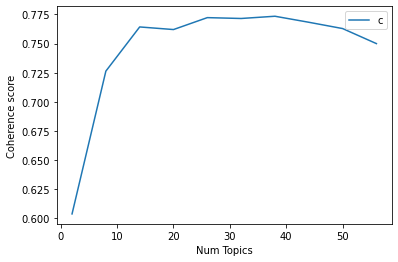

In [50]:
limit=60; start=2; step=6;
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

In [51]:
for no_of_topics, cv in zip(range(2, 60, 6), coherence_values):
  print("Num Topics:", no_of_topics, " - Coherence Value:", round(cv, 4))

Num Topics: 2  - Coherence Value: 0.6038
Num Topics: 8  - Coherence Value: 0.7264
Num Topics: 14  - Coherence Value: 0.7643
Num Topics: 20  - Coherence Value: 0.7621
Num Topics: 26  - Coherence Value: 0.7723
Num Topics: 32  - Coherence Value: 0.7716
Num Topics: 38  - Coherence Value: 0.7735
Num Topics: 44  - Coherence Value: 0.7683
Num Topics: 50  - Coherence Value: 0.7629
Num Topics: 56  - Coherence Value: 0.75


In [52]:
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=14, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=100,
                                           passes=10,
                                           alpha='auto',
                                           per_word_topics=True)

**Printing Topics**

In [53]:
pprint(lda_model.print_topics())
doc_lda = lda_model[corpus]

[(0,
  '0.098*"undefined" + 0.025*"cell" + 0.025*"disease" + 0.022*"patient" + '
  '0.020*"disorder" + 0.020*"characteristic" + 0.018*"clinical" + '
  '0.018*"etiology" + 0.014*"child" + 0.014*"woman"'),
 (1,
  '0.075*"undefined" + 0.028*"optimization" + 0.020*"system" + 0.016*"explain" '
  '+ 0.015*"state" + 0.015*"term" + 0.015*"supraglottic" + 0.015*"device" + '
  '0.013*"normal" + 0.013*"concept"'),
 (2,
  '0.052*"undefined" + 0.041*"value" + 0.020*"truth" + 0.020*"quantification" '
  '+ 0.017*"occurrence" + 0.017*"malignant" + 0.017*"detect" + '
  '0.017*"associate" + 0.017*"nodule" + 0.017*"fluid"'),
 (3,
  '0.033*"work" + 0.032*"response" + 0.028*"undefined" + 0.027*"undefine" + '
  '0.022*"probability" + 0.021*"patient" + 0.019*"pain" + 0.019*"non" + '
  '0.019*"still" + 0.019*"group"'),
 (4,
  '0.068*"undefined" + 0.039*"undefine" + 0.026*"behavior" + 0.020*"primary" + '
  '0.020*"detection" + 0.020*"case" + 0.017*"activity" + 0.015*"change" + '
  '0.013*"value" + 0.013*"repor

**Topic Visualization**

In [54]:
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(lda_model, corpus, id2word)
vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
10    -0.220346 -0.077938       1        1  19.614311
5     -0.127599  0.161848       2        1  12.091543
0      0.061356 -0.124335       3        1  11.525713
4      0.045711  0.074679       4        1  10.653557
1      0.024210 -0.011528       5        1   7.088217
12    -0.016799 -0.078025       6        1   6.992525
9      0.031845 -0.047636       7        1   6.153072
11     0.018857 -0.008148       8        1   5.533849
2      0.022646 -0.025037       9        1   4.869209
8      0.067165  0.116447      10        1   4.241888
3      0.040507  0.029304      11        1   4.075118
7      0.023716 -0.009242      12        1   3.819431
6      0.009245 -0.011496      13        1   2.625811
13     0.019487  0.011108      14        1   0.715755, topic_info=          Term        Freq       Total Category  logprob  loglift
14    undefine   21.000000   21.000000  Default  30.0000  30.0000
6          use    8.000000    8.000000  Default  29.0000  29.0000
1    undefined  111.000000  111.000000  Default  28.0000  28.0000
11     culture   11.000000   11.000000  Default  27.0000  27.0000
123    starter    4.000000    4.000000  Default  26.0000  26.0000
..         ...         ...         ...      ...      ...      ...
3       detect    0.011605    1.734628  Topic14  -6.7773  -0.0675
4        error    0.011605    1.628422  Topic14  -6.7773  -0.0044
5    precision    0.011605    1.052502  Topic14  -6.7773   0.4321
7     valgrind    0.011605    1.052502  Topic14  -6.7773   0.4321
8        value    0.011605    5.867151  Topic14  -6.7773  -1.2861

[558 rows x 6 columns], token_table=      Topic      Freq        Term
term                             
773      11  0.838368    abnormal
163       9  0.950117  accelerate
463       2  0.695386    acentric
124       1  0.546450        acid
124       8  0.273225        acid
...     ...       ...         ...
88        6  0.333017        work
88       11  0.666034        work
807       3  0.696838       world
407       6  0.910638        year
761      10  0.855712       yield

[456 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[11, 6, 1, 5, 2, 13, 10, 12, 3, 9, 4, 8, 7, 14])

**Summarization of LDA Topics**
Using NLP to extract solution for Medical Plagarism
Computer unified assistance for statistical biomedicine architecture
Processing medical information using NLP
Retrieving information efficiently using customized linguistics
Generating current engineering software models using NLP
NLP for text mining in helath and medicine industry
Base for Art labelling platform technique using NLP
NLP for extracting and Reviewing application techniques
NLP for machine based syntactic feature recognition
NLP toolkit for sentiment and opinion review analysis
Extarcting information from radiology infant pnuemonia
Retrieving defetcts of surveys
Evaluating challenges of clinical records
Extracting reviews from clinical systems

## (2) (8 points) Generate K topics by using LSA, the number of topics K should be decided by the coherence score, then summarize what are the topics. You may refer the code here:

https://www.datacamp.com/community/tutorials/discovering-hidden-topics-python

**Importing LSA model**

In [55]:
# Write your code here

from gensim.models import LsiModel

**Bulding Model**

In [56]:
lsamodel = LsiModel(corpus, 20, id2word)

**Computing coherence value for LSA**

In [57]:
def compute_coherence_values_lsi(dictionary, doc_term_matrix, doc_clean, stop, start=2, step=3):
    coherence_values = []
    model_list = []
    for num_topics in range(start, stop, step):
        # generate LSA model
        model = LsiModel(doc_term_matrix, num_topics=20, id2word = dictionary)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=doc_clean, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())
    return model_list, coherence_values

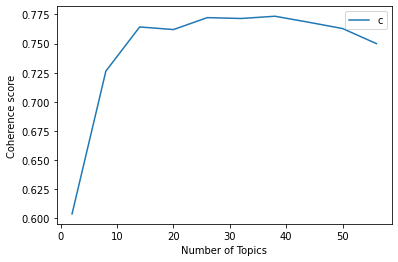

In [58]:
start,stop,step=2,60,6
model_list_lsa, coherence_values_lsa = compute_coherence_values_lsi(id2word, corpus,after_lemmatization,stop, start, step)
x = range(start, stop, step)
plt.plot(x, coherence_values)
plt.xlabel("Number of Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

In [59]:
for no_of_topics, cv in zip(range(2, 60, 6), coherence_values_lsa):
  print("Num Topics:", no_of_topics, " - Coherence Value:", round(cv, 4))

Num Topics: 2  - Coherence Value: 0.4331
Num Topics: 8  - Coherence Value: 0.4706
Num Topics: 14  - Coherence Value: 0.4667
Num Topics: 20  - Coherence Value: 0.4547
Num Topics: 26  - Coherence Value: 0.4524
Num Topics: 32  - Coherence Value: 0.457
Num Topics: 38  - Coherence Value: 0.4535
Num Topics: 44  - Coherence Value: 0.4521
Num Topics: 50  - Coherence Value: 0.4777
Num Topics: 56  - Coherence Value: 0.4581


**Printing Topics**

In [60]:
pprint(lsamodel.print_topics())

[(0,
  '-0.953*"undefined" + -0.071*"define" + -0.068*"use" + -0.063*"study" + '
  '-0.052*"patient" + -0.051*"culture" + -0.050*"value" + -0.045*"fraction" + '
  '-0.045*"petroleum" + -0.042*"previously"'),
 (1,
  '-0.696*"undefine" + -0.388*"culture" + -0.295*"mixed" + -0.140*"acid" + '
  '-0.139*"lactic" + -0.130*"production" + -0.123*"fermentation" + '
  '-0.113*"starter" + -0.099*"straw" + -0.098*"use"'),
 (2,
  '0.455*"undefine" + -0.301*"culture" + -0.257*"mixed" + '
  '-0.224*"fermentation" + 0.223*"patient" + -0.215*"acid" + -0.205*"lactic" + '
  '-0.192*"use" + -0.173*"production" + 0.152*"trial"'),
 (3,
  '0.300*"starter" + 0.256*"cheese" + -0.237*"temperature" + 0.219*"ripen" + '
  '0.203*"natural" + 0.203*"milk" + -0.195*"culture" + -0.190*"mixed" + '
  '0.184*"raw" + 0.184*"long"'),
 (4,
  '0.296*"fraction" + 0.269*"petroleum" + 0.262*"correlation" + 0.259*"define" '
  '+ 0.239*"use" + 0.226*"temperature" + -0.178*"patient" + -0.162*"mixed" + '
  '-0.157*"culture" + 0.149

**Summarization of LSA Topics**
NLP for clinical review system
NLP for clinical report detection
Electronic based medical record extraction using NLP
Systematic Review of unstructured opinion information using NLP
Extraction of medical and suicidal elctronic information
NLP for sentimental review
NLP for health and sytematic reviews
Automatic detection and text processing of clinical information
Clinical information extraction using deep learning
NLP for semenatical representation of survey text
Review of information retrieval using NLP
Clinical architecture extraction
Summary of detection techniques
Software for respiratory detection using deep learning
Machine learning solution for active health survey
Technique for research process detection
Retrieval process for research care and information mining
Home automation control and voice detection using IOT
Efficient soluiton for chinese cluster and whister graphs using NLP
Challenges for home automation control using NLP

## (3) (4 points) Compare the results generated by the two topic modeling algorithms, which one is better? You should explain the reasons in details.

Latent Semantic Analysis has lower accuracy than Latent Dirichlet allocation has better accuracy. Here, The Coherence value for optimal number of topics for LSA is 45 where as for LDA is 73. From this we will get to know that Accuracy for LDA is better. LDA has better accuracy that means we can easily generalize LDA model to other new documents. LSA has less interpretability among the topics beacuse of dimensionality reduction where as we interpret topic very easily in LDA. I got 14 topics for LDA which are highly interpretable than 20 topics of LSA. LSA has less efficient representation.